# Relax,Inc. Take Home Challenge

Defining an "adopted user" as a user who has logged into the product on three separate
days in at least one seven day period , identify which factors predict future user adoption .

## Imports

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import balanced_accuracy_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

In [4]:
user_engage = pd.read_csv('takehome_user_engagement.csv')

In [70]:
users = pd.read_csv('takehome_users.csv')

In [6]:
user_engage.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [5]:
user_engage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [7]:
# Convert time_stamp to datetime and create new column with just day
user_engage['time_stamp'] = pd.to_datetime(user_engage['time_stamp'])
user_engage['day'] = user_engage['time_stamp'].dt.date

In [8]:
def adopted(day):
    user = day['user_id']
    subset = user_engage[user_engage['user_id'] == user]
    time_start = day['time_stamp']
    time_range = pd.date_range(end=time_start, periods=7)
    adopteduser = sum(x in subset['day'].unique().tolist() for x in time_range)
    #user_engage.loc[subset.index,'adopted'] = np.where(adopteduser >= 3, 1, 0)
    return adopteduser >= 3

In [9]:
adopted_list = user_engage.apply(adopted, axis=1)

In [10]:
user_engage['adopted'] = adopted_list

In [11]:
adopted = user_engage[user_engage['adopted'] == True]

In [17]:
user_list = adopted['user_id'].unique()

There were 1602 users of the total 12000 users that became adopted users

# Factors that lead to adoption

With a target columns called adopted now in the engagement dateframe, we will add that to the users dataframe and run a classification model to predict whether a user was adopted.  Then we will select the major features that lead to a user adopting Relax,Inc.

In [71]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [72]:
users['adopted'] = np.where(users['object_id'].isin(user_list), 1, 0)

In [73]:
users_copy = users.copy(deep=True)

In [74]:
users_copy.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0


In [75]:
users_copy = users_copy.fillna(users_copy.mean())

In [76]:
# Encode Dummy Features and remove the previously encoded datetime features
df_copy = pd.get_dummies(users_copy)
X = df_copy.drop('adopted', axis=1)
y = df_copy['adopted']
oversample = SMOTE()
X_smote, y_smote = oversample.fit_resample(X,y)

# Model Preparation and Selection

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X_smote,y_smote, test_size= 0.3, random_state=42, stratify=y_smote)
model = RandomForestClassifier()
clf = model.fit(X_train, y_train)
y_pred = clf.predict(X_test)
target_names = ['Not Adopted', 'Adopted']
clf_rep = classification_report(y_test, y_pred, target_names=target_names)

In [79]:
print(clf_rep)

              precision    recall  f1-score   support

 Not Adopted       0.97      0.72      0.83      3120
     Adopted       0.78      0.97      0.87      3119

    accuracy                           0.85      6239
   macro avg       0.87      0.85      0.85      6239
weighted avg       0.87      0.85      0.85      6239



In [80]:
train_pred = clf.predict(X_train)
train_bal_acc = balanced_accuracy_score(y_train, train_pred)
test_bal_acc = balanced_accuracy_score(y_test, y_pred)

results = pd.DataFrame({'Train Balanced Accuracy': train_bal_acc, 'Test Balanced Accuracy': test_bal_acc}, index = ['df'])
print(results)

    Train Balanced Accuracy  Test Balanced Accuracy
df                      1.0                0.848714


# Which features are most important?

In [81]:
feature_importances = pd.DataFrame(clf.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances

,importance
last_session_creation_time,0.297026
creation_source_ORG_INVITE,0.059914
creation_source_PERSONAL_PROJECTS,0.054564
org_id,0.047426
invited_by_user_id,0.039091
...,...
creation_time_2013-08-06 03:17:54,0.000000
name_Troedel Sara,0.000000
name_Trommler Dominik,0.000000
name_Trommler Lukas,0.000000


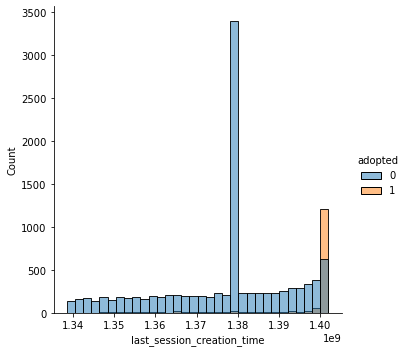

In [92]:
sns.displot(x='last_session_creation_time', data=df_copy, hue=df_copy['adopted'])

<AxesSubplot:xlabel='creation_source_ORG_INVITE', ylabel='Count'>

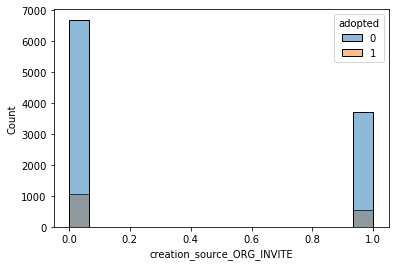

In [93]:
sns.histplot(x='creation_source_ORG_INVITE', data=df_copy, hue=df_copy['adopted'])